In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_predict, cross_validate, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()


df_normal_quality = pd.read_csv('dataframes/df_normal_quality.csv', index_col= 0).reset_index(drop = True)
y = df_normal_quality.SalePrice
X = df_normal_quality.drop(['SalePrice', 'PID'], axis =1).copy()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)
numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)


# Lasso 
## Tuned with Optuna 

In [116]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")               

numerical_preprocessor = RobustScaler()


preprocessor = ColumnTransformer(
    [
        ("robust_scaler", numerical_preprocessor, numerical_columns),
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ]
)



lasso = Lasso(alpha = 0.00030733929099045147)

lasso_pipe = Pipeline(steps=[("Preprocess", preprocessor), 
                             ("Regressor", TransformedTargetRegressor(regressor = Lasso(alpha = 0.00030733929099045147),
                                                                func =np.log, inverse_func=np.exp))])


lasso_pipe_SHAP = Pipeline(steps = [("Preprocess", preprocessor), ('lasso', lasso)])
                         
scores = cross_val_score(lasso_pipe, X, y, cv = kf, error_score='raise')

scores_SHAP = cross_val_score(lasso_pipe_SHAP, X, y, cv = kf, error_score='raise')

print('Lasso')
print('score', scores.mean())
print('standard deviation', scores.std())
print('      ')

lasso_pipe.fit(X,y)

lasso_predictions = lasso_pipe.predict(X)
print('predicted prices', lasso_predictions)

lasso_mae = mean_absolute_error(y, lasso_predictions)
print('Mean Absolute Error:', lasso_mae)

lasso_mpv = lasso_predictions.mean()
print ('Mean Predicted Home Value', lasso_mpv)

mhv = y.mean()
print ('Mean  Home Value', mhv)
print('      ')

print('Lasso SHAP')
print('score', scores_SHAP.mean())
print('standard deviation', scores_SHAP.std())

Lasso
score 0.9508124989217249
standard deviation 0.004995040204432598
      
predicted prices [125417.29914791 130118.74949454 115891.54733895 ... 153058.38303178
 224554.74105895 223794.23727269]
Mean Absolute Error: 10280.912930379654
Mean Predicted Home Value 172914.8587998538
Mean  Home Value 173427.01285897984
      
Lasso SHAP
score 0.9212817148520605
standard deviation 0.01128453562749722


## Lasso feature Importance 

In [46]:
lasso_pipe.fit(X, y)

# Extracting feature importances
# Get the coefficients from the Lasso model
lasso_regressor = lasso_pipe.named_steps['Regressor'].regressor_
coefficients = lasso_regressor.coef_

# Get the feature names after preprocessing
transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# Combine the feature names and coefficients into a DataFrame
feature_importance_lasso = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': coefficients})

# Sort the DataFrame by importance
feature_importance_lasso = feature_importance_lasso.sort_values(by='Importance', ascending=False)


feature_importance_lasso['Feature'] = feature_importance_lasso['Feature'].str.replace('robust_scaler__', '', regex=False)
feature_importance_lasso['Feature'] = feature_importance_lasso['Feature'].str.replace('one-hot-encoder__', 'OHE__', regex=False)
feature_importance_lasso

Feature  Importance
0                    GrLivArea    0.162424
9                  OverallQual    0.113826
11                   YearBuilt    0.095025
75   OHE__Neighborhood_Crawfor    0.092007
93   OHE__Neighborhood_Somerst    0.057523
..                         ...         ...
76   OHE__Neighborhood_Edwards   -0.037729
184          OHE__CentralAir_N   -0.038329
116        OHE__BldgType_Twnhs   -0.044640
56       OHE__MSZoning_C (all)   -0.091002
82   OHE__Neighborhood_MeadowV   -0.107461

[216 rows x 2 columns]

## Lasso SHAP
### One hot encoded categories left apart and log transformation not undone

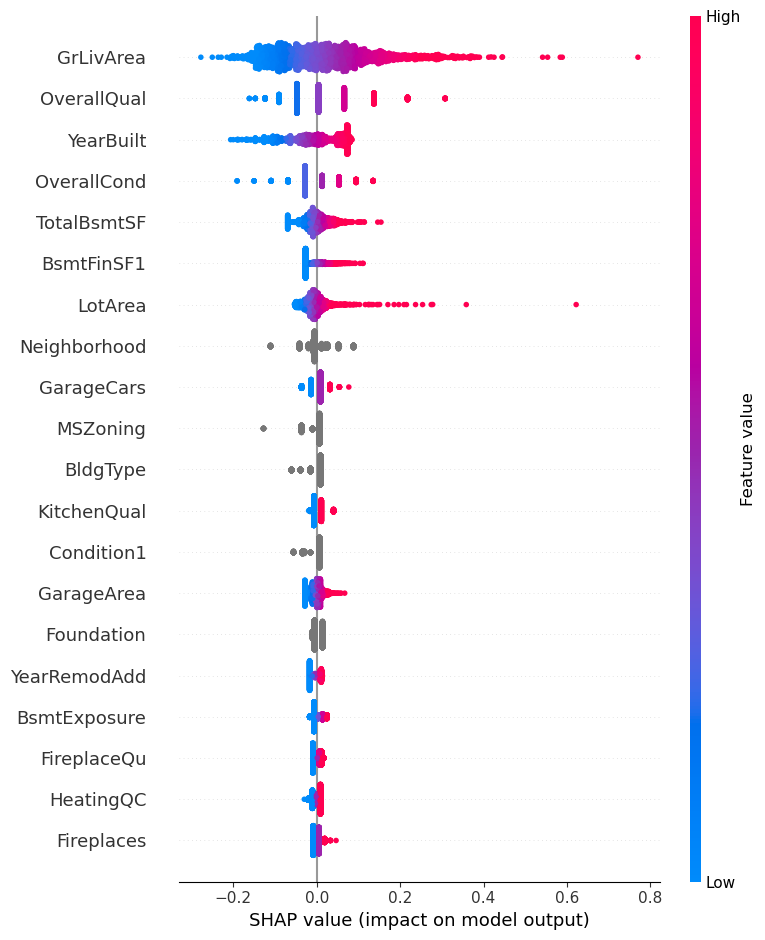

In [101]:
lasso_pipe.fit(X,y)

explainer_lasso_log = shap.LinearExplainer(lasso_pipe.named_steps['Regressor'].regressor_,
                          masker = lasso_pipe.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_lass_log = explainer_lasso_log(lasso_pipe.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_lasso_log = pd.DataFrame(shap_values_lass_log.values, columns=transformed_feature_names)

categorical_prefixes = categorical_columns_selector(X)
categorical_prefixes = ["one-hot-encoder__" + word for word in categorical_prefixes]
categorical_prefixes

for prefix in categorical_prefixes:
    # Get columns that start with the prefix
    columns = [col for col in transformed_feature_names if col.startswith(prefix)]
    
    # Calculate mean SHAP value for these columns
    shap_values_df_lasso_log[prefix] = shap_values_df_lasso_log[columns].sum(axis=1)
    
    # Drop the individual encoded columns
    shap_values_df_lasso_log.drop(columns=columns, inplace=True)

# Get rid of prefixes
shap_values_df_lasso_log.columns = shap_values_df_lasso_log.columns.str.replace('robust_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_lasso_log.columns = shap_values_df_lasso_log.columns.str.replace('one-hot-encoder__', 
                                                                    '', 
                                                                    regex=False)

# Create a shap.Explanation with scaled shap values and correct feature names 
exp_lasso_log = shap.Explanation(shap_values_df_lasso_log.values, 
                       shap_values_lass_log.base_values,
                       X_new_order)

shap.summary_plot(exp_lasso_log)

## Lasso SHAP
### One hot encoded categories left apart

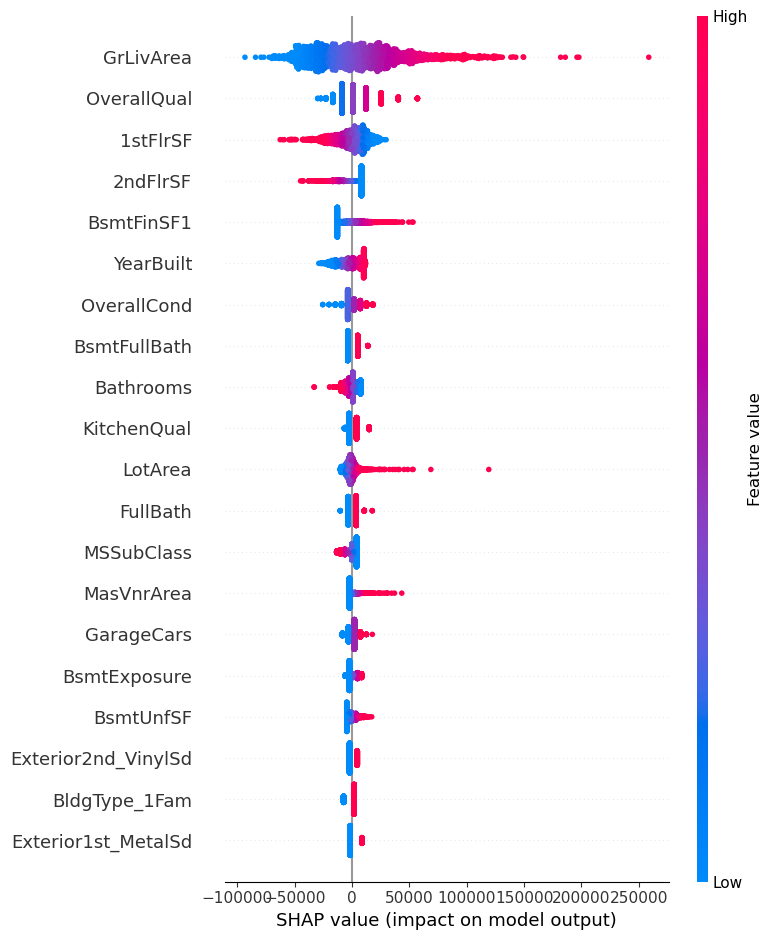

In [8]:
lasso_pipe_SHAP.fit(X,y)

explainer_lasso = shap.LinearExplainer(lasso_pipe_SHAP.named_steps['lasso'],
                          masker = lasso_pipe_SHAP.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_lasso = explainer_lasso(lasso_pipe_SHAP.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = lasso_pipe_SHAP.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_lasso = pd.DataFrame(shap_values_lasso.values, columns=transformed_feature_names)


# Get rid of prefixes
shap_values_df_lasso.columns = shap_values_df_lasso.columns.str.replace('robust_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_lasso.columns = shap_values_df_lasso.columns.str.replace('one-hot-encoder__', 
                                                                    '', 
                                                                    regex=False)

df_lasso = pd.DataFrame(lasso_pipe.named_steps['Preprocess'].transform(X))
df_lasso.columns = shap_values_df_lasso.columns
df_lasso[numerical_columns] = X[numerical_columns]
df_lasso
# Create a shap.Explanation with scaled shap values and correct feature names 
exp_all_lasso = shap.Explanation(shap_values_df_lasso.values, 
                       shap_values_lasso.base_values,
                       df_lasso)

shap.summary_plot(exp_all_lasso)

## Lasso SHAP
### Features combined 

In [9]:
lasso_pipe_SHAP.fit(X,y)

explainer_lasso_comb = shap.LinearExplainer(lasso_pipe_SHAP.named_steps['lasso'],
                          masker = lasso_pipe_SHAP.named_steps['Preprocess'].transform(X))
# Calculate SHAP values for the transformed test set
shap_values_lasso_comb = explainer_lasso(lasso_pipe_SHAP.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = lasso_pipe_SHAP.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_lasso_comb = pd.DataFrame(shap_values_lasso_comb.values, columns=transformed_feature_names)

# correct categorical prefixes so encoded variables can be combined"
categorical_prefixes = categorical_columns_selector(X)
categorical_prefixes = ["one-hot-encoder__" + word for word in categorical_prefixes]
categorical_prefixes

for prefix in categorical_prefixes:
    # Get columns that start with the prefix
    columns = [col for col in transformed_feature_names if col.startswith(prefix)]
    
    # Calculate mean SHAP value for these columns
    shap_values_df_lasso_comb[prefix] = shap_values_df_lasso_comb[columns].sum(axis=1)
    
    # Drop the individual encoded columns
    shap_values_df_lasso_comb.drop(columns=columns, inplace=True)

# find the base_value and use it to convert shap values back to dollars
# Use this to find the dollar value home with just that particular feature
# the subtract the bv of the home to see the exact value for that feature 
    
# Get rid of prefixes
shap_values_df_lasso_comb.columns = shap_values_df_lasso_comb.columns.str.replace('robust_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_lasso_comb.columns = shap_values_df_lasso_comb.columns.str.replace('one-hot-encoder__', 
                                                                    '', 
                                                                    regex=False)

# reorder X columns so the original values are in the same order as the shap df
X_new_order = list(numerical_columns) + list(categorical_columns)
X_new_order =X[X_new_order]

# Create a shap.Explanation with scaled shap values and correct feature names 
exp_lasso_comb = shap.Explanation(shap_values_df_lasso_comb.values, 
                       shap_values_lasso_comb.base_values,
                       X_new_order)

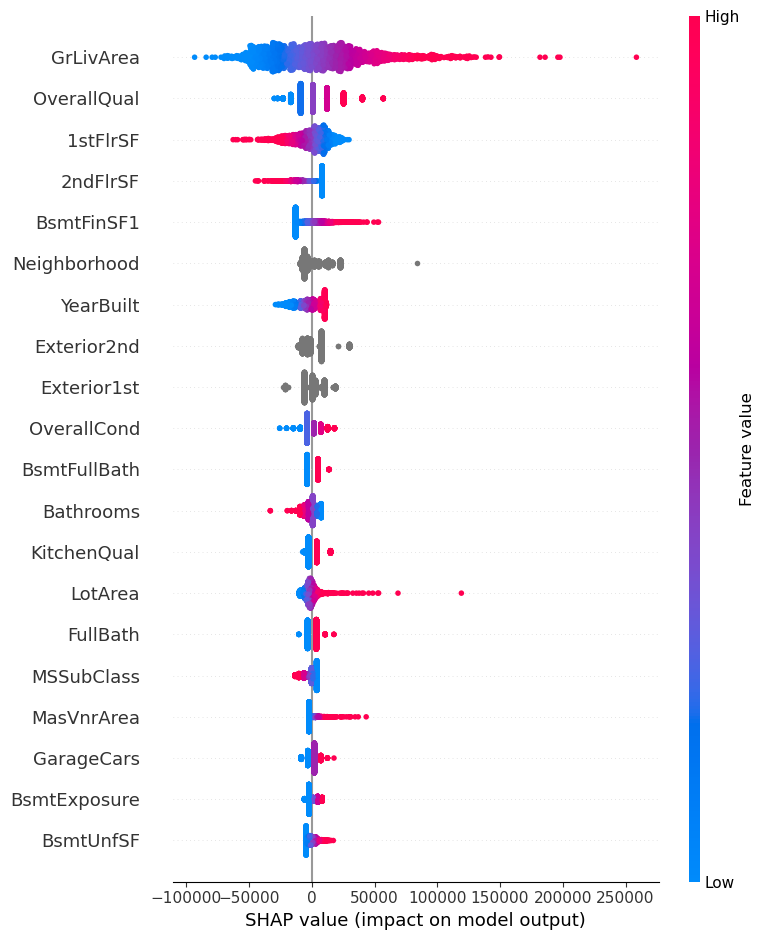

In [10]:
shap.summary_plot(exp_lasso_comb)

In [104]:
X.Neighborhood.value_counts()

Neighborhood
NAmes      391
CollgCr    226
OldTown    199
Edwards    148
Sawyer     132
Gilbert    128
NWAmes     112
Somerst    112
SawyerW    103
Mitchel     98
NridgHt     97
BrkSide     95
Crawfor     75
IDOTRR      65
NoRidge     61
Timber      48
SWISU       38
MeadowV     34
StoneBr     33
ClearCr     31
BrDale      26
NPkVill     22
Veenker     20
Blmngtn     19
Blueste     10
Greens       8
GrnHill      1
Landmrk      1
Name: count, dtype: int64

In [105]:
X.loc[X.Neighborhood == 'GrnHill']

GrLivArea  MSSubClass MSZoning  LotFrontage  LotArea Street  Alley  \
530       1295         120       RM    65.236303     8239   Pave    0.0   

     LotShape  LandContour  Utilities  ... 3SsnPorch  ScreenPorch PoolYN  \
530         2            4          4  ...         0            0     no   

    PoolQC Fence MoSold YrSold  SaleType  SaleCondition  Bathrooms  
530    0.0    NO     11   2006       WD          Normal        2.0  

[1 rows x 78 columns]

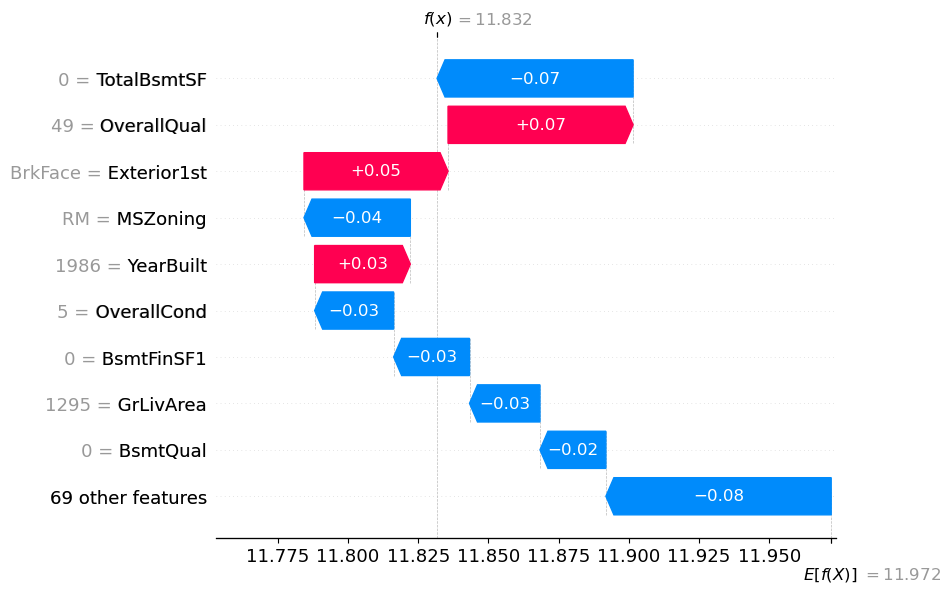

In [106]:
shap.waterfall_plot(exp_lasso_log[530], max_display= 10)

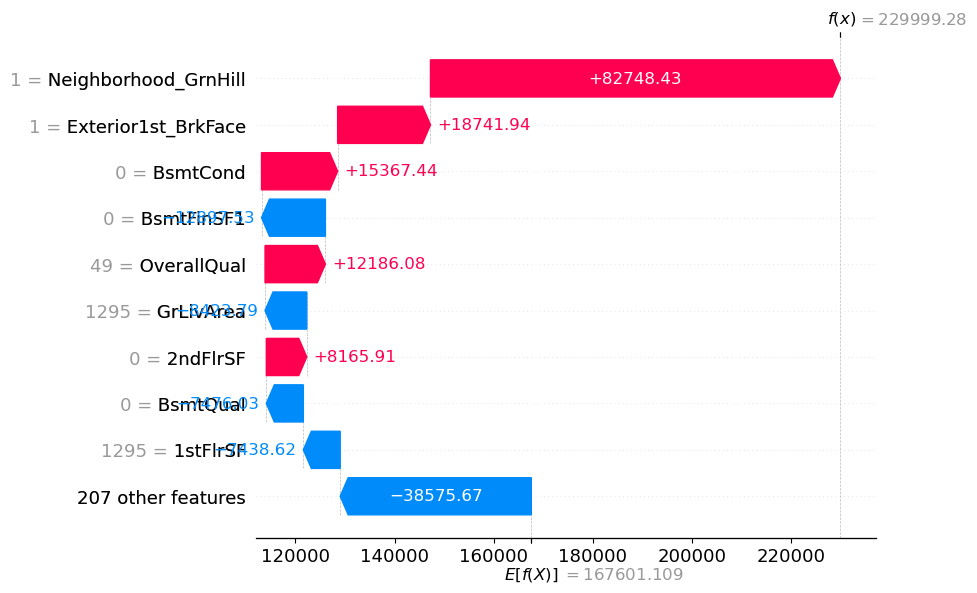

In [108]:
shap.waterfall_plot(exp_all_lasso[530], max_display= 10)

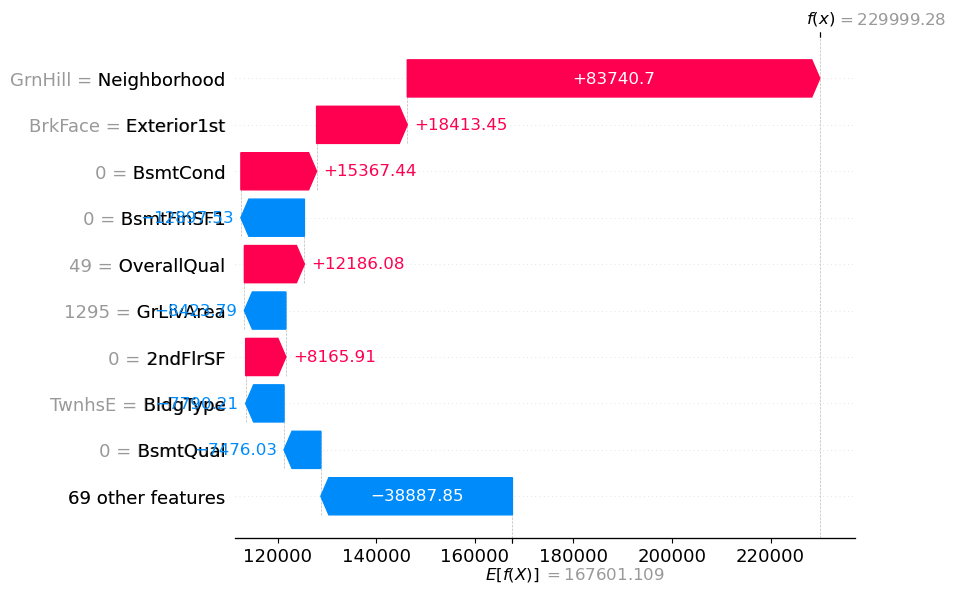

In [109]:
shap.waterfall_plot(exp_lasso_comb[530], max_display= 10)

# XGB 
## Tuned with Optuna

In [13]:
categorical_preprocessor_OHE = OneHotEncoder(handle_unknown="ignore", drop = None)
categorical_preprocessor_O =  OrdinalEncoder(handle_unknown="use_encoded_value", 
                                           unknown_value= -1)
numerical_preprocessor = StandardScaler()

preprocessor_OHE = ColumnTransformer(
    [
        ("standard_scaler", numerical_preprocessor, numerical_columns),
        ("encoder", categorical_preprocessor_OHE, categorical_columns),
    ]
)

preprocessor_O = ColumnTransformer(
    [
        ("standard_scaler", numerical_preprocessor, numerical_columns),
        ("encoder", categorical_preprocessor_O, categorical_columns),
    ]
)


xgb =  XGBRegressor(max_depth= 4,
                    learning_rate= 0.04643973848790804,
                    subsample= 0.5797329944770706,
                    colsample_bytree= 0.527504939004116,
                    n_estimators= 905,
                    min_child_weight= 3)


xgb_pipe_OHE = Pipeline(steps=[("Preprocess", preprocessor_OHE), 
                               ("Regressor", TransformedTargetRegressor(regressor =xgb,
                                                                          func =np.log, inverse_func=np.exp))])
xgb_pipe_OHE_SHAP = Pipeline(steps=[("Preprocess", preprocessor_OHE), ("XGB", xgb)])
                             

xgb_pipe_O = Pipeline(steps=[("Preprocess", preprocessor_O), ("XGB", xgb)])


scores_OHE = cross_val_score(xgb_pipe_OHE, X, y, cv = kf, error_score='raise')

scores_OHE_SHAP = cross_val_score(xgb_pipe_OHE_SHAP, X, y, cv = kf, error_score='raise')

scores_O = cross_val_score(xgb_pipe_O, X, y, cv = kf, error_score='raise')


print('XGB OneHot')
print('score', scores_OHE.mean())
print('standard deviation', scores_OHE.std())

xgb_pipe_OHE.fit(X,y)

xgb_pipe_OHE_SHAP.fit(X,y)

xgb_OHE_predictions = xgb_pipe_OHE.predict(X)
print('predicted prices', xgb_OHE_predictions)

xgb_OHE_mae = mean_absolute_error(y, xgb_OHE_predictions)
print('Mean Absolute Error:', xgb_OHE_mae)

xgb_OHE_mpv = xgb_OHE_predictions.mean()
print ('Mean Predicted Home Value', xgb_OHE_mpv)

mhv = y.mean()
print ('Mean  Home Value', mhv)

print('         ')
print('XGB Ordinal')
print('score', scores_O.mean())
print('standard deviation', scores_O.std())

xgb_pipe_O.fit(X,y)

xgb_O_predictions = xgb_pipe_O.predict(X)
print('predicted prices', xgb_O_predictions)

xgb_O_mae = mean_absolute_error(y, xgb_O_predictions)
print('Mean Absolute Error:', xgb_O_mae)

xgb_O_mpv = xgb_O_predictions.mean()
print ('Mean Predicted Home Value', xgb_O_mpv)

mhv = y.mean()
print ('Mean  Home Value', mhv)



XGB OneHot
score 0.9538790152827454
standard deviation 0.004298267507064383
predicted prices [123684.31  136620.55  121025.016 ... 144983.69  219554.66  219634.23 ]
Mean Absolute Error: 4284.175757809151
Mean Predicted Home Value 173185.95
Mean  Home Value 173427.01285897984
         
XGB Ordinal
score 0.9514839204613024
standard deviation 0.0037904597932120862
predicted prices [122851.55 136797.58 121850.96 ... 144140.02 222936.81 216420.14]
Mean Absolute Error: 3953.066630612409
Mean Predicted Home Value 173423.78
Mean  Home Value 173427.01285897984


## XGB feature imprtance 
### One hot encoder

In [14]:
# Extracting feature importances
# Get the coefficients from the Lasso model
xgb_regressor =xgb_pipe_OHE.named_steps['Regressor'].regressor_
coefficients = xgb_regressor.feature_importances_

# Get the feature names after preprocessing
transformed_feature_names = xgb_pipe_OHE.named_steps['Preprocess'].get_feature_names_out()

# Combine the feature names and coefficients into a DataFrame
feature_importance_xgb_oh = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': coefficients})

# Sort the DataFrame by importance
feature_importance_xgb_oh = feature_importance_xgb_oh.sort_values(by='Importance', ascending=False)


feature_importance_xgb_oh['Feature'] = feature_importance_xgb_oh['Feature'].str.replace('standard_scaler__', '', regex=False)
feature_importance_xgb_oh['Feature'] = feature_importance_xgb_oh['Feature'].str.replace('encoder__', 'OHE__', regex=False)
feature_importance_xgb_oh.head()


Feature  Importance
9   OverallQual    0.075910
41   GarageCars    0.053035
44   GarageCond    0.051183
39  FireplaceQu    0.049327
54    Bathrooms    0.048753

## XGB feature imprtance 
### Ordinal encoder

In [41]:
xgb_pipe_OHE_SHAP.fit(X, y)

# Extracting feature importances
# Get the coefficients from the Lasso model
#xgb_regressor = xgb_pipe.named_steps['Regressor'].regressor_
#feature_imp = xgb_regressor.feature_importances_
feature_imp = xgb_pipe_OHE_SHAP.named_steps['XGB'].feature_importances_
# Get the feature names after preprocessing
transformed_feature_names = xgb_pipe_OHE_SHAP.named_steps['Preprocess'].get_feature_names_out()

# Combine the feature names and coefficients into a DataFrame
feature_importance_xgb_o = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': feature_imp})

# Sort the DataFrame by importance
feature_importance_xgb_o = feature_importance_xgb_o.sort_values(by='Importance', ascending=False)

feature_importance_xgb_o['Feature'] = feature_importance_xgb_o['Feature'].str.replace('standard_scaler__', '', regex=False)
feature_importance_xgb_o['Feature'] = feature_importance_xgb_o['Feature'].str.replace('encoder__', '', regex=False)

feature_importance_xgb_o.head(5)

Feature  Importance
9   OverallQual    0.187945
41   GarageCars    0.128450
14    ExterQual    0.125266
35  KitchenQual    0.053433
54    Bathrooms    0.046194

In [11]:
xgb_pipe_O.fit(X, y)

# Extracting feature importances
# Get the coefficients from the Lasso model
#xgb_regressor = xgb_pipe.named_steps['Regressor'].regressor_
#feature_imp = xgb_regressor.feature_importances_
feature_imp = xgb_pipe_O.named_steps['XGB'].feature_importances_
# Get the feature names after preprocessing
transformed_feature_names = xgb_pipe_O.named_steps['Preprocess'].get_feature_names_out()

# Combine the feature names and coefficients into a DataFrame
feature_importance_xgb_o = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': feature_imp})

# Sort the DataFrame by importance
feature_importance_xgb_o = feature_importance_xgb_o.sort_values(by='Importance', ascending=False)

feature_importance_xgb_o['Feature'] = feature_importance_xgb_o['Feature'].str.replace('standard_scaler__', '', regex=False)
feature_importance_xgb_o['Feature'] = feature_importance_xgb_o['Feature'].str.replace('encoder__', '', regex=False)

feature_importance_xgb_o.head(5)

Feature  Importance
14    ExterQual    0.266232
9   OverallQual    0.186079
41   GarageCars    0.110318
35  KitchenQual    0.062518
0     GrLivArea    0.036734

## XGB SHAP
### One hot encoder...Target transformation left as log dollars

In [125]:
xgb_pipe_OHE.fit(X,y)
# This is the same code as Lasso one hot combined but for xgb one hot 
explainer_xgb = shap.Explainer(xgb_pipe_OHE.named_steps['Regressor'].regressor_,
                          masker = xgb_pipe_OHE.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_xgb = explainer_xgb(xgb_pipe_OHE.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = xgb_pipe_OHE.named_steps['Preprocess'].get_feature_names_out()

 97%|=================== | 2272/2333 [00:24<00:00]       

In [129]:

shap_values_df_xgb_log

GrLivArea  MSSubClass  LotFrontage   LotArea     Alley  LotShape  \
0     -0.105507   -0.001649    -0.003796 -0.020670 -0.000298  0.000756   
1     -0.050407   -0.000304    -0.008387 -0.056378 -0.000033 -0.000148   
2     -0.060342   -0.002798    -0.004213 -0.026084 -0.000200  0.000237   
3     -0.058715    0.005493     0.007991  0.005804 -0.000136  0.000863   
4      0.051397    0.004712     0.003421  0.002871 -0.000189 -0.000353   
...         ...         ...          ...       ...       ...       ...   
2328  -0.100637   -0.000618     0.008903 -0.001226 -0.000358 -0.000327   
2329   0.067251   -0.005147     0.001320  0.037937 -0.000288  0.000431   
2330   0.117281   -0.002100     0.008229 -0.043232 -0.000258  0.000002   
2331   0.091278    0.003719     0.002787  0.000222 -0.000169 -0.000448   
2332   0.090390    0.003535     0.004756  0.003644 -0.000220  0.000445   

      LandContour  Utilities  LandSlope  OverallQual  ...  Foundation  \
0        0.000528        0.0  -0.000156    -0.005384  ...         0.0   
1        0.000528        0.0  -0.000185    -0.041280  ...         0.0   
2        0.000553        0.0  -0.000200    -0.044227  ...         0.0   
3        0.000524        0.0  -0.000439    -0.115822  ...         0.0   
4        0.000381        0.0  -0.000284     0.136486  ...         0.0   
...           ...        ...        ...          ...  ...         ...   
2328     0.000524        0.0  -0.000292    -0.003900  ...         0.0   
2329     0.000624        0.0  -0.000383    -0.136020  ...         0.0   
2330    -0.009296        0.0  -0.000239    -0.047437  ...         0.0   
2331     0.000345        0.0  -0.000258     0.058954  ...         0.0   
2332     0.000319        0.0  -0.000336     0.140577  ...         0.0   

      Heating  CentralAir  Electrical  GarageType  GarageYN  PoolYN  Fence  \
0         0.0         0.0         0.0         0.0       0.0     0.0    0.0   
1         0.0         0.0         0.0         0.0       0.0     0.0    0.0   
2         0.0         0.0         0.0         0.0       0.0     0.0    0.0   
3         0.0         0.0         0.0         0.0       0.0     0.0    0.0   
4         0.0         0.0         0.0         0.0       0.0     0.0    0.0   
...       ...         ...         ...         ...       ...     ...    ...   
2328      0.0         0.0         0.0         0.0       0.0     0.0    0.0   
2329      0.0         0.0         0.0         0.0       0.0     0.0    0.0   
2330      0.0         0.0         0.0         0.0       0.0     0.0    0.0   
2331      0.0         0.0         0.0         0.0       0.0     0.0    0.0   
2332      0.0         0.0         0.0         0.0       0.0     0.0    0.0   

      SaleType  SaleCondition  
0          0.0            0.0  
1          0.0            0.0  
2          0.0            0.0  
3          0.0            0.0  
4          0.0            0.0  
...        ...            ...  
2328       0.0            0.0  
2329       0.0            0.0  
2330       0.0            0.0  
2331       0.0            0.0  
2332       0.0            0.0  

[2333 rows x 239 columns]

In [131]:
shap_values_df_xgb_log = pd.DataFrame(shap_values_xgb.values, 
                                      columns=transformed_feature_names)
shap_values_df_xgb_log

standard_scaler__GrLivArea  standard_scaler__MSSubClass  \
0                      -0.105507                    -0.001649   
1                      -0.050407                    -0.000304   
2                      -0.060342                    -0.002798   
3                      -0.058715                     0.005493   
4                       0.051397                     0.004712   
...                          ...                          ...   
2328                   -0.100637                    -0.000618   
2329                    0.067251                    -0.005147   
2330                    0.117281                    -0.002100   
2331                    0.091278                     0.003719   
2332                    0.090390                     0.003535   

      standard_scaler__LotFrontage  standard_scaler__LotArea  \
0                        -0.003796                 -0.020670   
1                        -0.008387                 -0.056378   
2                        -0.004213                 -0.026084   
3                         0.007991                  0.005804   
4                         0.003421                  0.002871   
...                            ...                       ...   
2328                      0.008903                 -0.001226   
2329                      0.001320                  0.037937   
2330                      0.008229                 -0.043232   
2331                      0.002787                  0.000222   
2332                      0.004756                  0.003644   

      standard_scaler__Alley  standard_scaler__LotShape  \
0                  -0.000298                   0.000756   
1                  -0.000033                  -0.000148   
2                  -0.000200                   0.000237   
3                  -0.000136                   0.000863   
4                  -0.000189                  -0.000353   
...                      ...                        ...   
2328               -0.000358                  -0.000327   
2329               -0.000288                   0.000431   
2330               -0.000258                   0.000002   
2331               -0.000169                  -0.000448   
2332               -0.000220                   0.000445   

      standard_scaler__LandContour  standard_scaler__Utilities  \
0                         0.000528                         0.0   
1                         0.000528                         0.0   
2                         0.000553                         0.0   
3                         0.000524                         0.0   
4                         0.000381                         0.0   
...                            ...                         ...   
2328                      0.000524                         0.0   
2329                      0.000624                         0.0   
2330                     -0.009296                         0.0   
2331                      0.000345                         0.0   
2332                      0.000319                         0.0   

      standard_scaler__LandSlope  standard_scaler__OverallQual  ...  \
0                      -0.000156                     -0.005384  ...   
1                      -0.000185                     -0.041280  ...   
2                      -0.000200                     -0.044227  ...   
3                      -0.000439                     -0.115822  ...   
4                      -0.000284                      0.136486  ...   
...                          ...                           ...  ...   
2328                   -0.000292                     -0.003900  ...   
2329                   -0.000383                     -0.136020  ...   
2330                   -0.000239                     -0.047437  ...   
2331                   -0.000258                      0.058954  ...   
2332                   -0.000336                      0.140577  ...   

      encoder__SaleType_COD  encoder__SaleType_CWD  encoder__SaleType_Con  \
0                  0.000

In [130]:
X_new_order

GrLivArea  MSSubClass  LotFrontage  LotArea  Alley  LotShape  \
0           856          30    62.472926     7890    0.0         1   
1          1049         120    42.000000     4235    0.0         1   
2          1001          30    60.000000     6060    0.0         1   
3          1039          70    80.000000     8146    0.0         1   
4          1665          60    70.000000     8400    0.0         1   
...         ...         ...          ...      ...    ...       ...   
2328        952          30    70.105866     8854    0.0         1   
2329       1733          20   108.318076    13680    0.0         2   
2330       2002          90    82.000000     6270    0.0         1   
2331       1842          60    69.884162     8826    0.0         1   
2332       1911          60    80.000000     9554    0.0         2   

      LandContour  Utilities  LandSlope  OverallQual  ...  Foundation  \
0               4          4          3           36  ...      CBlock   
1               4          4          3           25  ...      CBlock   
2               4          4          3           25  ...      BrkTil   
3               4          4          3           16  ...      BrkTil   
4               4          4          3           64  ...       PConc   
...           ...        ...        ...          ...  ...         ...   
2328            4          4          3           36  ...      BrkTil   
2329            4          4          3            9  ...        Slab   
2330            2          4          3           25  ...      CBlock   
2331            4          4          3           49  ...       PConc   
2332            4          4          3           64  ...       PConc   

      Heating  CentralAir  Electrical  GarageType  GarageYN  PoolYN  Fence  \
0        GasA           Y       SBrkr      Detchd       yes      no     NO   
1        GasA           Y       SBrkr      Attchd       yes      no     NO   
2        GasA           Y       SBrkr      Detchd       yes      no     NO   
3        GasA           Y       SBrkr      Detchd       yes      no     NO   
4        GasA           Y       SBrkr      Attchd       yes      no     NO   
...       ...         ...         ...         ...       ...     ...    ...   
2328     Grav           N       FuseF      Detchd       yes      no     NO   
2329     GasA           Y       FuseA      Attchd       yes      no     NO   
2330     GasA           N       FuseA      2Types       yes      no     NO   
2331     GasA           Y       SBrkr      Attchd       yes      no     NO   
2332     GasA           Y       SBrkr      Attchd       yes      no     NO   

      SaleType  SaleCondition  
0          WD          Normal  
1          WD          Normal  
2          WD          Normal  
3          WD          Normal  
4          WD          Normal  
...        ...            ...  
2328       WD          Normal  
2329       WD          Normal  
2330       WD          Normal  
2331       WD          Normal  
2332       WD          Normal  

[2333 rows x 78 columns]

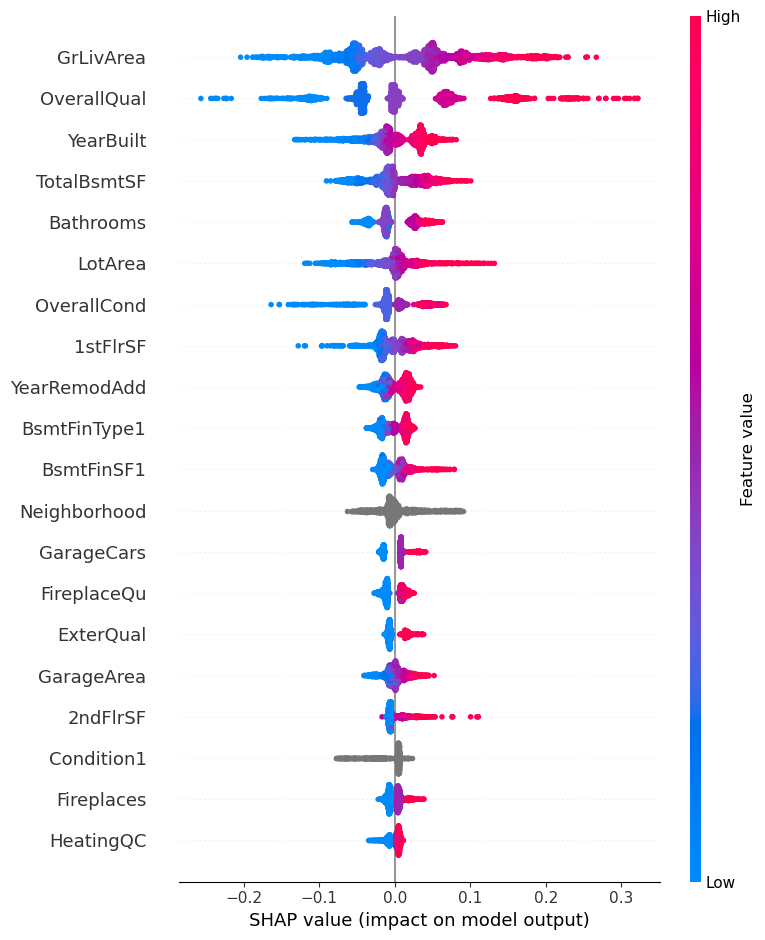

In [138]:
# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_xgb_log = pd.DataFrame(shap_values_xgb.values, 
                                      columns=transformed_feature_names)
    
categorical_prefixes = categorical_columns_selector(X)
categorical_prefixes = ["encoder__" + word for word in categorical_prefixes]

for prefix in categorical_prefixes:
    # Get columns that start with the prefix
    columns = [col for col in transformed_feature_names if col.startswith(prefix)]
    
    # Calculate mean SHAP value for these columns
    shap_values_df_xgb_log[prefix] = shap_values_df_xgb_log[columns].sum(axis=1)
    
    # Drop the individual encoded columns
    shap_values_df_xgb_log.drop(columns=columns, inplace=True)
# Get rid of prefixes
shap_values_df_xgb_log.columns = shap_values_df_xgb_log.columns.str.replace('standard_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_xgb_log.columns = shap_values_df_xgb_log.columns.str.replace('encoder__', 
                                                                    '', 
                                                                    regex=False)

exp_xgb_log = shap.Explanation(shap_values_df_xgb_log.values, 
                       shap_values_xgb.base_values,
                       X_new_order)

shap.summary_plot(exp_xgb_log, max_display= 20)

## XGB SHAP
### One hot encoder

In [16]:
xgb_pipe_OHE_SHAP.fit(X,y)
# This is the same code as Lasso one hot combined but for xgb one hot 
explainer_xgb_ohe = shap.Explainer(xgb_pipe_OHE_SHAP.named_steps['XGB'],
                          masker = xgb_pipe_OHE_SHAP.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_xgb_ohe = explainer_xgb_ohe(xgb_pipe_OHE_SHAP.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = xgb_pipe_OHE_SHAP.named_steps['Preprocess'].get_feature_names_out()

 98%|===================| 2276/2333 [00:24<00:00]        

In [17]:
# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_xgb_ohe = pd.DataFrame(shap_values_xgb_ohe.values, columns=transformed_feature_names)
    
# Get rid of prefixes
shap_values_df_xgb_ohe.columns = shap_values_df_xgb_ohe.columns.str.replace('standard_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_xgb_ohe.columns = shap_values_df_xgb_ohe.columns.str.replace('encoder__', 
                                                                    '', 
                                                                    regex=False)


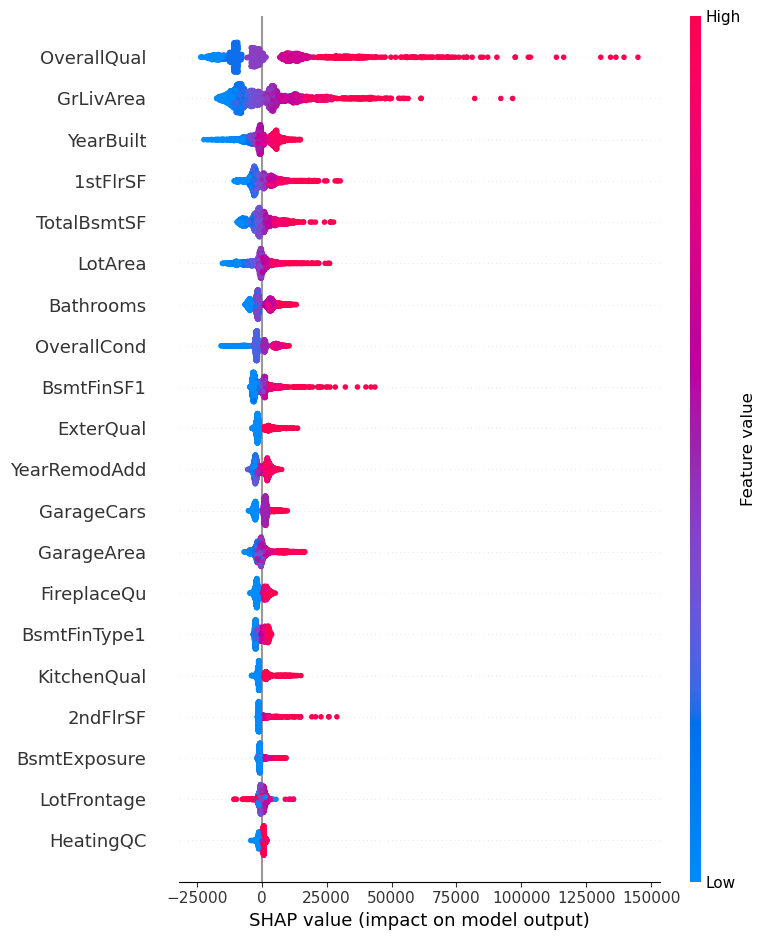

In [18]:
# Create explanation varaible using SHAP values, base values, and original values 
exp_all_xgb_ohe = shap.Explanation(shap_values_df_xgb_ohe.values, 
                       shap_values_xgb_ohe.base_values,
                       df_lasso)

shap.summary_plot(exp_all_xgb_ohe, max_display= 20)

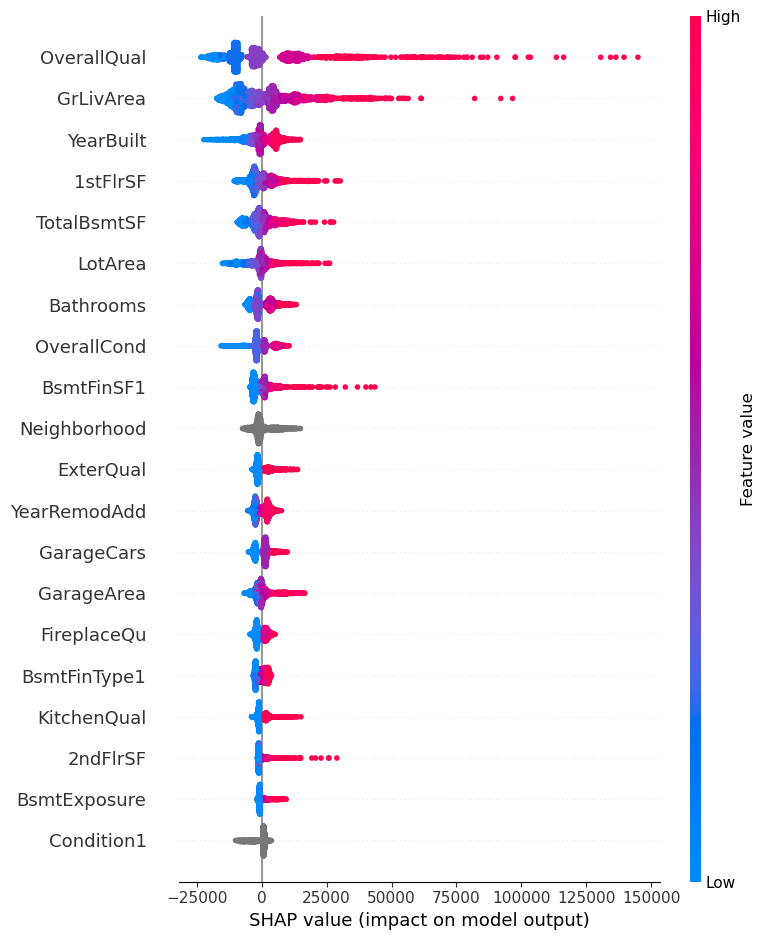

In [19]:
# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_xgb_ohe_comb = pd.DataFrame(shap_values_xgb_ohe.values, columns=transformed_feature_names)

#correct categorical prefixes so encoded variables can be combined"

categorical_prefixes = categorical_columns_selector(X)
categorical_prefixes = ["encoder__" + word for word in categorical_prefixes]
categorical_prefixes

for prefix in categorical_prefixes:
    # Get columns that start with the prefix
    columns = [col for col in transformed_feature_names if col.startswith(prefix)]
    
    # Calculate mean SHAP value for these columns
    shap_values_df_xgb_ohe_comb[prefix] = shap_values_df_xgb_ohe_comb[columns].sum(axis=1)
    
    # Drop the individual encoded columns
    shap_values_df_xgb_ohe_comb.drop(columns=columns, inplace=True)


# Get rid of prefixes
shap_values_df_xgb_ohe_comb.columns = shap_values_df_xgb_ohe_comb.columns.str.replace('standard_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_xgb_ohe_comb.columns = shap_values_df_xgb_ohe_comb.columns.str.replace('encoder__', 
                                                                    '', 
                                                                    regex=False)

exp_comb_xgb_ohe = shap.Explanation(shap_values_df_xgb_ohe_comb.values, 
                       shap_values_xgb_ohe.base_values,
                       X_new_order)

shap.summary_plot(exp_comb_xgb_ohe, max_display= 20)

## XGB SHAP
### Ordinal encoder

In [20]:
xgb_pipe_O.fit(X,y)

explainer_xgb_o = shap.Explainer(xgb_pipe_O.named_steps['XGB'],
                          masker = xgb_pipe_O.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_xgb_o = explainer_xgb_o(xgb_pipe_O.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = xgb_pipe_O.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_xgb_o = pd.DataFrame(shap_values_xgb_o.values, columns=transformed_feature_names)

shap_values_df_xgb_o.columns = shap_values_df_xgb_o.columns.str.replace('standard_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_xgb_o.columns = shap_values_df_xgb_o.columns.str.replace('encoder__', 
                                                                    '', 
                                                                    regex=False)


 99%|===================| 2319/2333 [00:25<00:00]        

In [21]:
exp_all_xgb_o = shap.Explanation(shap_values_df_xgb_o.values, 
                           shap_values_xgb_o.base_values, 
                           X_new_order
                         )

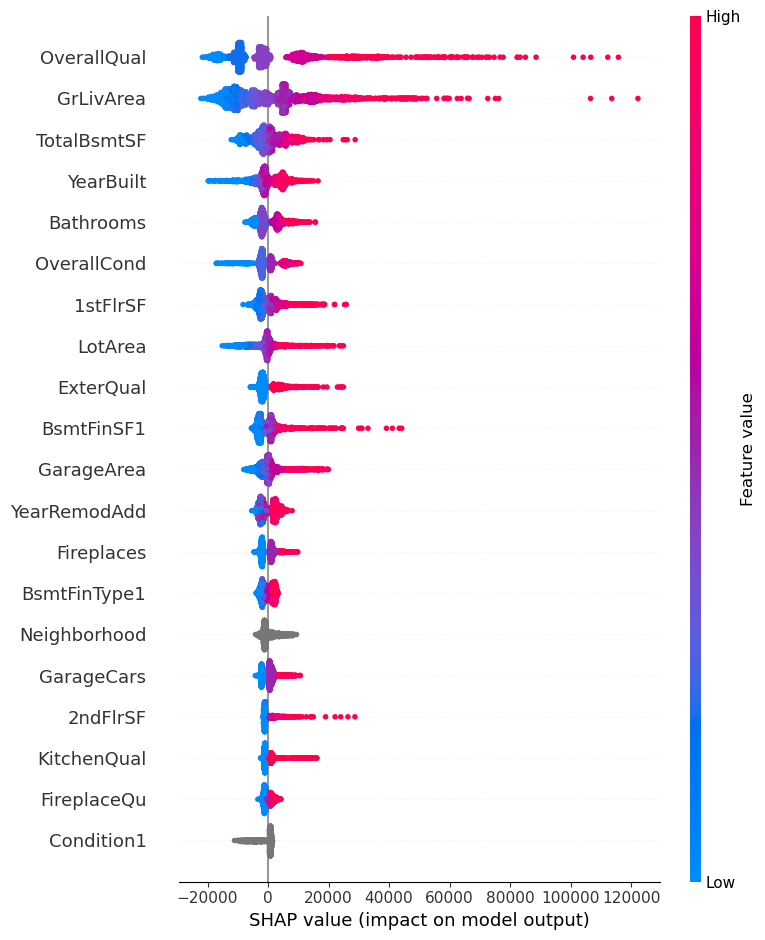

In [22]:
shap.summary_plot(exp_all_xgb_o, max_display= 20)


# Compare Lasso to XGB

In [30]:
df_predictions = df_normal_quality.copy()
df_predictions['Lasso'] = lasso_predictions
df_predictions['error_Lasso'] = df_predictions.SalePrice - df_predictions.Lasso
df_predictions['xgb'] = xgb_OHE_predictions
df_predictions['error_xgb'] = df_predictions.SalePrice - df_predictions.xgb
df_predictions[['SalePrice', 'Lasso',  'error_Lasso', 'xgb','error_xgb']]

SalePrice          Lasso   error_Lasso            xgb     error_xgb
0        126000  125417.299148    582.700852  123684.312500   2315.687500
1        139500  130118.749495   9381.250505  136620.546875   2879.453125
2        124900  115891.547339   9008.452661  121025.015625   3874.984375
3        114000  105123.287031   8876.712969  112510.101562   1489.898438
4        227000  223707.350576   3292.649424  213293.171875  13706.828125
...         ...            ...           ...            ...           ...
2328     121000  107056.493708  13943.506292  119838.703125   1161.296875
2329     139600  122895.059269  16704.940731  138721.578125    878.421875
2330     145000  153058.383032  -8058.383032  144983.687500     16.312500
2331     217500  224554.741059  -7054.741059  219554.656250  -2054.656250
2332     215000  223794.237273  -8794.237273  219634.234375  -4634.234375

[2333 rows x 5 columns]

In [32]:
df_predictions.loc[df_predictions.Neighborhood == 'GrnHill']

PID  GrLivArea  SalePrice  MSSubClass MSZoning  LotFrontage  \
530  916252170       1295     230000         120       RM    65.236303   

     LotArea Street  Alley  LotShape  ...  Fence  MoSold YrSold  SaleType  \
530     8239   Pave    0.0         2  ...     NO      11   2006       WD    

    SaleCondition Bathrooms          Lasso   error_Lasso            xgb  \
530        Normal       2.0  137547.487445  92452.512555  199176.984375   

        error_xgb  
530  30823.015625  

[1 rows x 84 columns]

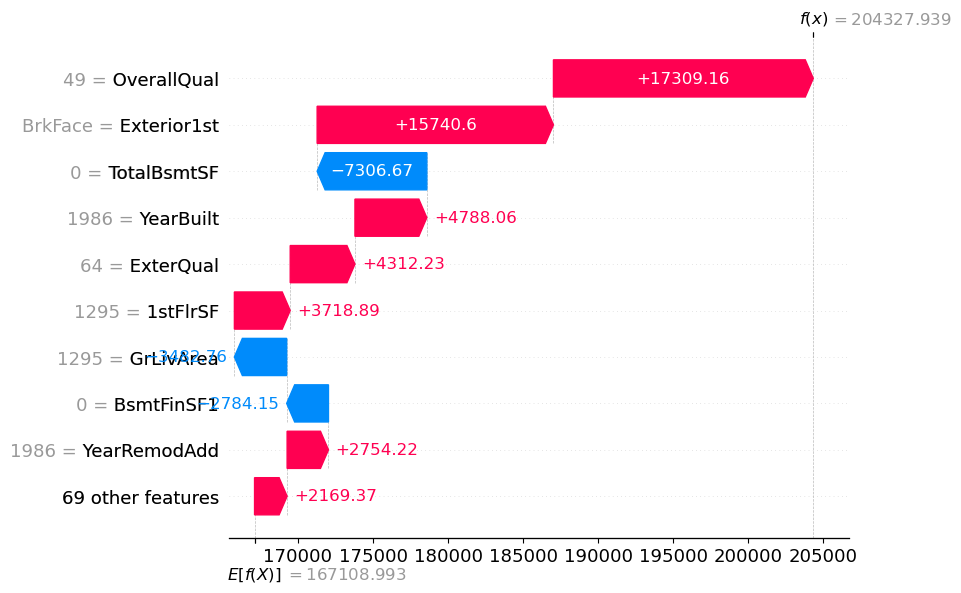

In [96]:
shap.waterfall_plot(exp_comb_xgb_ohe[530], max_display= 10)

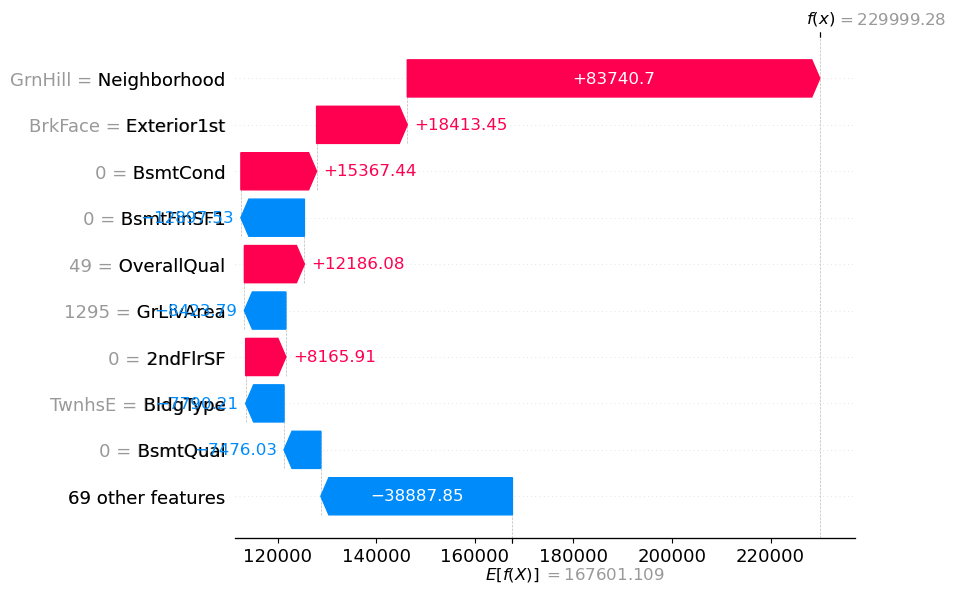

In [97]:
shap.waterfall_plot(exp_lasso_comb[530], max_display= 10)

In [27]:
import plotly.express as px
import pandas as pd

# Assuming X is a DataFrame and y, predictions are Series
# Combine y and predictions into a DataFrame for easy handling
data = pd.DataFrame({
    'GrLivArea': X['GrLivArea'],
    'OverallQual': X['OverallQual'],
    'Error': y - lasso_predictions
})

# Create the plot
fig = px.scatter(
    data, x='GrLivArea', y='Error',
    color=np.sqrt(X.OverallQual), 
    title=f'Lasso: Living Area vs. Prediction Error<br><sup>Mean Absolute Error: ${lasso_mae:.2f}</sup>',
    labels={'GrLivArea': 'Above Ground Living Area (Square Feet)', 
            'Error': 'Error ($)',
            'color': ''},
    color_continuous_scale='Turbo'
)

# Add a horizontal line at y=0
fig.add_shape(type="line",
              x0=min(data['GrLivArea']), x1=max(data['GrLivArea']),
              y0=0, y1=0,
              line=dict(color="red", dash="dash"))


fig.update_layout(
    yaxis_range=[-100000, 100000],
    yaxis_title_standoff=0  
)

fig.add_annotation(
    x=1.1,  # Adjust the x position as needed
    y=1.1,  # Adjust the y position as needed
    text="Overall<br>Quality",  # Custom legend title with line break
    showarrow=False,
    xref="paper",
    yref="paper",
    align="left",
    font=dict(size=13)
)
# Show plot
fig.show()

fig.write_image("images/lasso_error.png")

In [28]:
# xgb_predictions = xgb_pipe_OHE.predict(X)
# xgb_mae = mean_absolute_error(y, xgb_predictions)
import plotly.express as px
import pandas as pd

# Assuming X is a DataFrame and y, predictions are Series
# Combine y and predictions into a DataFrame for easy handling
data = pd.DataFrame({
    'GrLivArea': X['GrLivArea'],
    'OverallQual': X['OverallQual'],
    'Error': y - xgb_OHE_predictions
})

# Create the plot
fig = px.scatter(
    data, x='GrLivArea', y='Error',
    color=np.sqrt(X.OverallQual), 
    title=f'XGB: Living Area vs. Prediction Error<br><sup>Mean Absolute Error: ${xgb_OHE_mae:.2f}</sup>',
    labels={'GrLivArea': 'Above Ground Living Area (Square Feet)', 
            'Error': 'Error ($)', 
            'color': ''},
    color_continuous_scale='Turbo'
)

# Add a horizontal line at y=0
fig.add_shape(type="line",
              x0=min(data['GrLivArea']), x1=max(data['GrLivArea']),
              y0=0, y1=0,
              line=dict(color="red", dash="dash"))

fig.update_layout(
    yaxis_range=[-100000, 100000],
    yaxis_title_standoff=0
)

fig.add_annotation(
    x=1.1,  # Adjust the x position as needed
    y=1.1,  # Adjust the y position as needed
    text="Overall<br>Quality",  # Custom legend title with line break
    showarrow=False,
    xref="paper",
    yref="paper",
    align="left",
    font=dict(size=13)
)

# Show plot
fig.show()

fig.write_image("images/xgb_error.png")

In [119]:
# fig.show()
neighborhood_counts = X['Neighborhood'].value_counts()

# Filter the data to include only neighborhoods with more than 10 homes
filtered_neighborhoods = neighborhood_counts[neighborhood_counts > 10].index
filtered_X = X[X['Neighborhood'].isin(filtered_neighborhoods)]

import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.loc[filtered_X.index].Neighborhood,
    y=shap_values_df_xgb_ohe_comb.loc[filtered_X.index].Neighborhood,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.loc[filtered_X.index].Neighborhood,
    y= shap_values_df_lasso_comb.loc[filtered_X.index].Neighborhood,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Neighborhood SHAP Values',
    xaxis=dict(title='Neighborhood'),
    yaxis=dict(title='SHAP Values ($)'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

#fig.write_image("images/neighborhood_SHAP.png")

In [147]:
X.loc[X.Neighborhood == 'NridgHt'].OverallQual.mean()

67.69072164948453

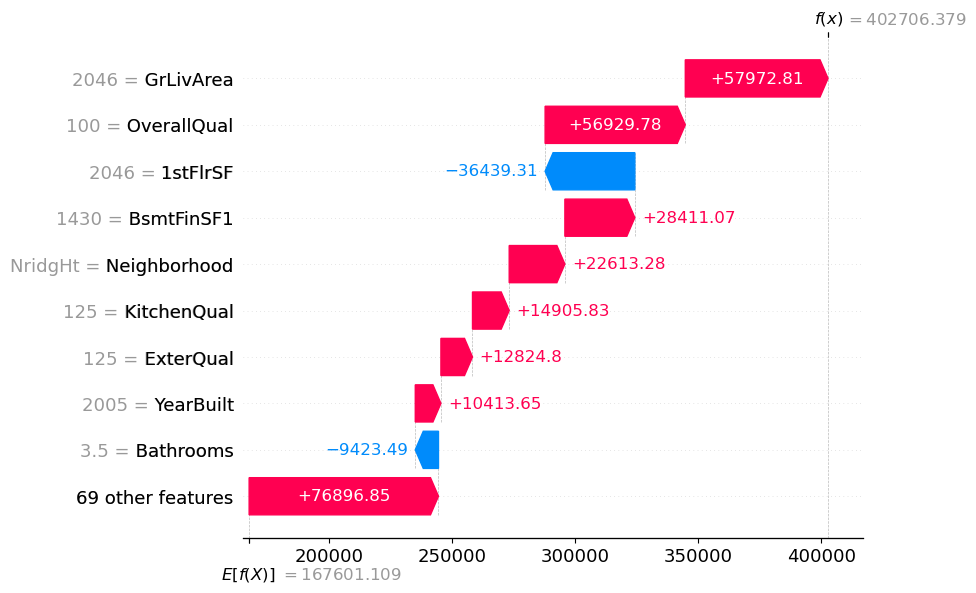

In [146]:
shap.waterfall_plot(exp_lasso_comb[25], max_display= 10)

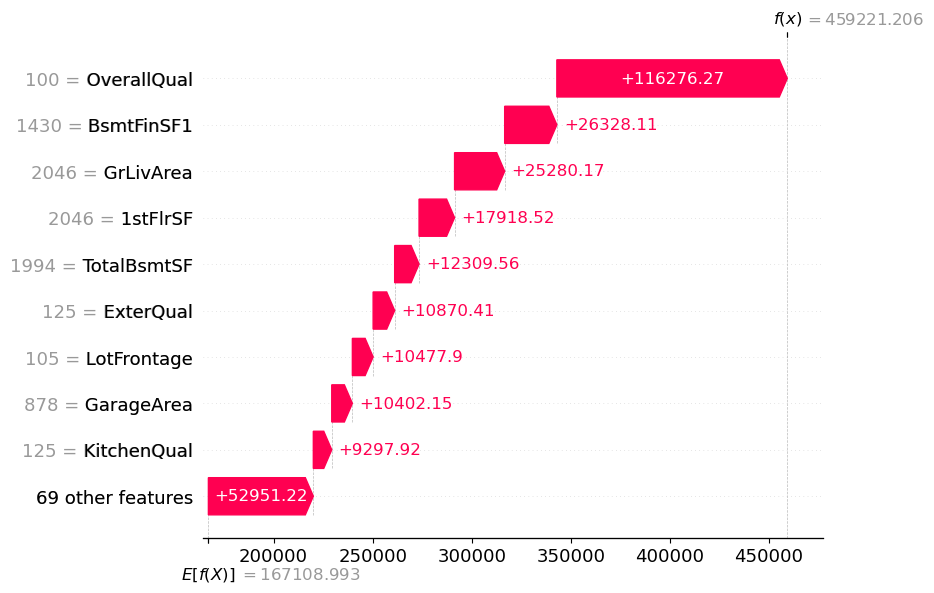

In [145]:
shap.waterfall_plot(exp_comb_xgb_ohe[25], max_display= 10)

In [139]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.Neighborhood,
    y=shap_values_df_xgb_log.Neighborhood,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.Neighborhood,
    y= shap_values_df_lasso_log.Neighborhood,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Neighborhood SHAP Values',
    xaxis=dict(title='Neighborhood'),
    yaxis=dict(title='SHAP Values ($)'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [150]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.OverallQual,
    y=shap_values_df_xgb_log.OverallQual,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.OverallQual,
    y= shap_values_df_lasso_log.OverallQual,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Quality SHAP Values',
    xaxis=dict(title='Quality'),
    yaxis=dict(title='SHAP Values ($)'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [151]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.OverallQual,
    y=shap_values_df_xgb_ohe_comb.OverallQual,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.OverallQual,
    y= shap_values_df_lasso_comb.OverallQual,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Quality SHAP Values',
    xaxis=dict(title='Quality'),
    yaxis=dict(title='SHAP Values ($)'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [48]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x= X.GrLivArea,
    y=shap_values_df_xgb_ohe_comb.GrLivArea,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.GrLivArea,
    y= shap_values_df_lasso_comb.GrLivArea,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Living Area SHAP Values',
    xaxis=dict(title='Above Ground Living Area (Square Feet)'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [50]:
fig = px.scatter(
    x=shap_values_df_xgb_ohe_comb.GrLivArea,
    y=shap_values_df_xgb_ohe_comb.OverallQual,
    color=np.sqrt(X.OverallQual), 
    title='hi',
    color_continuous_scale='Turbo'
)

fig.show()

In [49]:
fig = px.scatter(
    x=shap_values_df_lasso_comb.GrLivArea,
    y=shap_values_df_lasso_comb.OverallQual,
    color=np.sqrt(X.OverallQual), 
    title='hi',
    color_continuous_scale='Turbo'
)

fig.show()

In [ ]:
shap_values_df_xgb

In [89]:
shap_values_df_lasso_log.LotArea

0      -0.014794
1      -0.036493
2      -0.025658
3      -0.013274
4      -0.011766
          ...   
2328   -0.009070
2329    0.019581
2330   -0.024411
2331   -0.009237
2332   -0.004915
Name: LotArea, Length: 2333, dtype: float64

In [92]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.LotArea,
    y=shap_values_df_xgb.LotArea,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x=X.LotArea,
    y= shap_values_df_lasso_log.LotArea,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Lot Area SHAP Values (log transformed)',
    xaxis=dict(title='Lot (square feet)'),
    yaxis=dict(title='SHAP Values (log $)'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [72]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.LotArea,
    y=shap_values_df_xgb_ohe_comb.LotArea,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x=X.LotArea,
    y= shap_values_df_lasso_comb.LotArea,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Lot Area SHAP Values',
    xaxis=dict(title='Lot (square feet)'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [73]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.GarageCars,
    y=shap_values_df_xgb_ohe_comb.GarageCars,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.GarageCars,
    y= shap_values_df_lasso_comb.GarageCars,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Garage Cars SHAP Values',
    xaxis=dict(title='Cars'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [66]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")               

numerical_preprocessor = RobustScaler()


preprocessor = ColumnTransformer(
    [
        ("robust_scaler", numerical_preprocessor, numerical_columns),
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ]
)


lasso = Lasso(alpha = 0.00030733929099045147)

X_pre = preprocessor.fit_transform(X)

y_log = np.log(y)

lasso.fit(X_pre, y_log)

predict_ = np.exp(lasso.predict(X_pre))
                           
# scores = cross_val_score(lasso_pipe, X, y, cv = kf, error_score='raise')

# print('Lasso')
# print('score', scores.mean())
# print('standard deviation', scores.std())

# lasso_pipe.fit(X,y)

# lasso_predictions = lasso_pipe.predict(X)
# print('predicted prices', lasso_predictions)

# lasso_mae = mean_absolute_error(y, lasso_predictions)
# print('Mean Absolute Error:', lasso_mae)

# lasso_mpv = lasso_predictions.mean()
# print ('Mean Predicted Home Value', lasso_mpv)

# mhv = y.mean()
# print ('Mean  Home Value', mhv)


In [69]:
lasso.fit(X_pre, y)

explainer = shap.Explainer(lasso, masker = X_pre)

# Calculate SHAP values for the transformed test set
shap_values = explainer(X_pre)

shap_values
# # Get feature names after transformation
# transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# # Convert SHAP values and transformed data to DataFrame for easier manipulation
# # transform Explanation type into a df with named columns 
# shap_values_df_lasso = pd.DataFrame(shap_values_lasso.values, columns=transformed_feature_names)

# bv = shap_values_lasso.base_values[0]
# dollar_shap_values_lasso = np.exp(bv + shap_values_df_lasso) - np.exp(bv)
    
# # Get rid of prefixes
# dollar_shap_values_lasso.columns = dollar_shap_values_lasso.columns.str.replace('robust_scaler__', 
#                                                                     '', 
#                                                                     regex=False)
# dollar_shap_values_lasso.columns = dollar_shap_values_lasso.columns.str.replace('one-hot-encoder__', 
#                                                                     '', 
#                                                                     regex=False)

# df_lasso = pd.DataFrame(lasso_pipe.named_steps['Preprocess'].transform(X))
# df_lasso.columns = dollar_shap_values_lasso.columns
# df_lasso[numerical_columns] = X[numerical_columns]
# df_lasso
# # Create a shap.Explanation with scaled shap values and correct feature names 
# exp_all_lasso = shap.Explanation(dollar_shap_values_lasso.values, 
#                        np.exp(shap_values_lasso.base_values),
#                        df_lasso)

.values =
array([[-4.72361840e+04,  2.89193714e+03,  9.16224391e+02, ...,
        -0.00000000e+00, -2.43505078e+00,  0.00000000e+00],
       [-3.01728773e+04, -6.25654590e+03,  2.36663850e+03, ...,
        -0.00000000e+00, -2.43505078e+00,  0.00000000e+00],
       [-3.44166012e+04,  2.89193714e+03,  1.09141997e+03, ...,
        -0.00000000e+00, -2.43505078e+00,  0.00000000e+00],
       ...,
       [ 5.40827253e+04, -3.20705156e+03, -4.67180445e+02, ...,
        -0.00000000e+00, -2.43505078e+00,  0.00000000e+00],
       [ 3.99369788e+04, -1.57557208e+02,  3.91171810e+02, ...,
        -0.00000000e+00, -2.43505078e+00,  0.00000000e+00],
       [ 4.60373319e+04, -1.57557208e+02, -3.25489498e+02, ...,
        -0.00000000e+00, -2.43505078e+00,  0.00000000e+00]])

.base_values =
array([167601.10881636, 167601.10881636, 167601.10881636, ...,
       167601.10881636, 167601.10881636, 167601.10881636])

.data =
array([[-0.91734198, -0.4       , -0.33139011, ...,  0.        ,
         1.        , 

In [59]:
np.exp(11.97202774)

158265.25603431257

In [74]:
xgb_pipe_OHE.fit(X,y)
# This is the same code as Lasso one hot combined but for xgb one hot 
explainer = shap.Explainer(xgb_pipe_OHE.named_steps['Regressor'].regressor_,
                          masker = xgb_pipe_OHE.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_xgb = explainer(xgb_pipe_OHE.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = xgb_pipe_OHE.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_xgb_df = pd.DataFrame(shap_values_xgb.values, columns=transformed_feature_names)
    
# Get rid of prefixes
shap_xgb_df.columns = shap_xgb_df.columns.str.replace('standard_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_xgb_df.columns = shap_xgb_df.columns.str.replace('encoder__', 
                                                                    '', 
                                                                    regex=False)

# Create explanation varaible using SHAP values, base values, and original values 
# test = shap.Explanation(shap_values_df_xgb_ohe.values, 
#                        shap_values_xgb_ohe.base_values,
#                        df_lasso)

# shap.summary_plot(exp_all_xgb_ohe, max_display= 20)

 97%|=================== | 2273/2333 [00:24<00:00]       

In [75]:
shap_values_xgb.base_values

array([11.9667094, 11.9667094, 11.9667094, ..., 11.9667094, 11.9667094,
       11.9667094])

In [78]:
np.exp(shap_values_xgb.base_values)

array([157425.7816752, 157425.7816752, 157425.7816752, ...,
       157425.7816752, 157425.7816752, 157425.7816752])

In [77]:
shap_values_xgb_o.base_values

array([167562.8383319, 167562.8383319, 167562.8383319, ...,
       167562.8383319, 167562.8383319, 167562.8383319])